# 4 Memory（内存管理）

## 一、先明确：LangGraph Memory 的核心定义

LangGraph 将Memory 定义为“AI智能体存储/检索信息的认知功能”，并按**记忆范围**分为两类：

|内存类型|	官网定义|	存储范围|	核心组件|	适用场景|
|--|--|--|--|--|
|短程内存（Short-term）|	单对话线程（Thread）内的记忆，随线程生命周期存在|	单个 Thread ID|	Checkpointer（如 MemorySaver）、State|	多轮对话上下文（如单用户单次聊天）|
|长程内存（Long-term）|	跨对话线程共享的记忆，独立于线程生命周期|	自定义 Namespace（如用户 ID）|	Store（如 InMemoryStore）|	跨会话用户偏好（如用户常驻信息）|


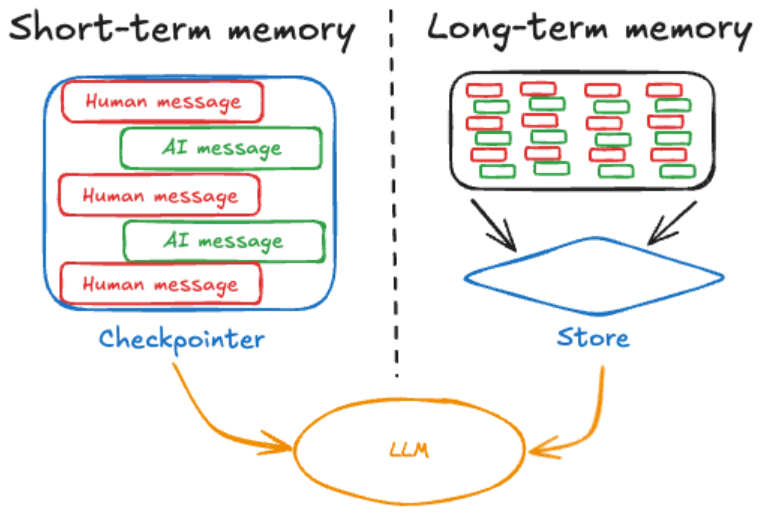

官网强调：LangGraph 的 Memory 不是独立模块，而是 **State（状态）+ 持久化组件（Checkpointer/Store）** 的组合 ——State 定义 “存什么”，Checkpointer/Store 定义 “怎么存 / 怎么取”。

## 二、前置准备：环境与依赖

In [ ]:
# 官网推荐安装命令（含LangGraph核心+向量存储+Checkpointer）
!pip install -U langgraph langgraph-checkpoint-sqlite langchain-core langchain-openai faiss-cpu

## 三、核心实践

### 实践1：短程内存（Short-term Memory）

**步骤1：定义State（内存存储结构）**

官网要求用`TypedDict`定义 `State`，配合`Annotated`指定 `Reducer`（处理 `State` 更新的规则）：

In [8]:
from typing import TypedDict, Annotated, Union
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.graph import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END

# 1. 定义State：存储对话消息（messages）+临时变量（如用户输入的文件ID）
class ConversationState(TypedDict):
    # add_messages
    messages: Annotated[list[BaseMessage], add_messages]
    # 临时变量：示例 ———— 存储用户上传的文件ID
    uploaded_file_ids: list[str]

**步骤2：定义节点函数（处理State流转）**

节点是 State 的 “操作单元”，官网要求节点函数接收 State，返回更新后的 State 片段：

In [17]:
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    api_key = os.getenv("UIUIAPI_API_KEY"),
    base_url = os.getenv("UIUIAPI_BASE_URL"),
    model="gpt-3.5-turbo",
    temperature=0.3
)

# 节点1：生成AI回复（读取messages，更新messages）
def generate_ai_response(state: ConversationState) -> dict:
    # 从state中读取会话历史
    messages = state["messages"]
    # LLM 生成回复
    ai_msg = llm.invoke(messages)
    # 返回更新的state片段（add_messages会自动合并到原有messages）
    return {"messages": [ai_msg]}

# 节点2：处理文件上传（更新uploaded_file_ids，单线程内临时存储）
def handle_file_upload(state: ConversationState, file_id: str) -> dict:
    existing_ids = state["uploaded_file_ids"]
    new_ids = existing_ids + [file_id]
    # 返回更新的state片段
    return {"uploaded_file_ids": new_ids}

# 节点3：清理旧消息（保留最近2条消息，避免token溢出）
def trim_old_messages(state: ConversationState) -> dict:
    # 获取当前所有消息
    messages = state["messages"]
    left_messages = [RemoveMessage(id=msg.id) for msg in messages[:-2]]
    
    return {"messages": left_messages}


**步骤3：构建Graph（管理State与节点流转）**

LangGraph 通过StateGraph定义节点间的流转逻辑，是短程内存的 “运行容器”：

In [18]:
# 1. 初始化State
graph = StateGraph(ConversationState)

# 2. 添加节点
graph.add_node("generate_response", generate_ai_response)
graph.add_node("upload_file", handle_file_upload)
graph.add_node("trim_messages", trim_old_messages)

# 3. 定义流转逻辑（官网规范：用add_edge指定节点顺序）
# 入口→生成回复→清理消息→结束
graph.set_entry_point("generate_response")
graph.add_edge("generate_response", "trim_messages")
graph.add_edge("trim_messages", END)

# 4. 绑定Checkpointer（持久化短程内存，按Thread ID隔离）
checkpointer = MemorySaver()  # 官网推荐：内存级Checkpointer（生产可用SQLiteCheckpoint）
graph_with_memory = graph.compile(checkpointer=checkpointer)


**步骤4：运行Graph（多轮对话，验证短程内存）**

In [19]:
config = {"configurable": {"thread_id": "user_changyun_001"}}

print("=== 第一轮对话 ===")
user_msg1 = HumanMessage(content="Hi! 我是Changyun，上传了一个文件，ID是file_123")
# 1. 先处理文件上传（手动触发upload_file节点）
graph_with_memory.update_state(
    config=config,
    updates=handle_file_upload({"messages": [], "uploaded_file_ids": []}, file_id="file_123")
)

# 2. 生成AI回复（触发generate_response→trim_messages）
result1 = graph_with_memory.invoke(
    {"messages": [user_msg1]},
    config=config,
)

# 打印结果
print("AI回复：", result1["messages"][-1].content)
print("当前文件ID列表：", result1["uploaded_file_ids"])
print("当前消息列表（已清理，保留2条）：", [msg.content for msg in result1["messages"]])


=== 第一轮对话 ===


TypeError: Pregel.update_state() got an unexpected keyword argument 'updates'

### 实践2：长程内存（Long-term Memory）

### 实践3：长对话处理（短程内存优化）